# Imports and Defaults

In [2]:
import json
import os
from functools import lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_theme(font_scale=1.6, style="whitegrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.dpi": 300,
})

seed = 1234
rng = np.random.default_rng(seed)

# Load Data

In [4]:
posterior_fname = "../../data/funnel100/baseline"

drghmc_sampler = "adapt_metric=False__damping=0.08__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drghmc__step_count_method=const_step_count__step_size_factor=2"
drhmc_sampler = "adapt_metric=False__damping=1.0__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drhmc__step_count_factor=0.9__step_size_factor=2"
nuts_sampler = "adapt_metric=False__metric=identity__sampler_type=nuts"

In [5]:
def get_fname(sampler, chain):
    return os.path.join(posterior_fname, sampler, f"history__chain={chain}.npz")

def get_chain_data(sampler, chain):
    data = np.load(get_fname(sampler, chain))
    return data["draws"], data["grad_evals"]

In [6]:
@lru_cache(maxsize=3)
def get_data(sampler):
    data_list, grad_list = [], []
    for chain in range(100):
        draws, grad_evals = get_chain_data(sampler, chain)
        data_list.append(draws)
        grad_list.append(np.array(grad_evals))
    
    # every individual chain contains a running sum of gradient evaluations
    # create a running sum of gradient evaluations over *all* chains
    for i in range(1, len(grad_list)):
        grad_list[i] += grad_list[i - 1][-1]
    
    return np.concatenate(data_list, axis=0), np.concatenate(grad_list)

In [7]:
c

In [8]:
drghmc_mean, drghmc_std = np.mean(drghmc_data, axis=0), np.std(drghmc_data, axis=0)
drhmc_mean, drhmc_std = np.mean(drhmc_data, axis=0), np.std(drhmc_data, axis=0)
nuts_mean, nuts_std = np.mean(nuts_data, axis=0), np.std(nuts_data, axis=0)

print(drghmc_mean[0], drghmc_std[0], drghmc_mean[1], drghmc_std[1], drghmc_mean[2], drghmc_std[2])
print(drhmc_mean[0], drhmc_std[0], drhmc_mean[1], drhmc_std[1], drhmc_mean[2], drhmc_std[2])
print(nuts_mean[0], nuts_std[0], nuts_mean[1], nuts_std[1], nuts_mean[2], nuts_std[2])

0.16370201740018173 3.015078225089878 -0.23854313491744306 7.144067607266496 0.30549673485438855 8.07897367410008
0.516286661392061 2.8774822616083635 -0.16982165863538753 8.904518644188165 -0.008536308473730747 8.538487416799978
0.5061576552391055 2.569647697137007 -0.024101474290328273 8.830126930028305 -0.023522902415731427 8.613316519393742


In [9]:
print(np.abs(drghmc_mean[0] - 0) / 3)
print(np.abs(drhmc_mean[0] - 0) / 3)
print(np.abs(nuts_mean[0] - 0) / 3)

0.054567339133393906
0.17209555379735367
0.16871921841303517


# Loss Plot

In [10]:
fname = "../../posteriors/funnel100/funnel100.analytic_params.json"
with open(fname, "r") as f:
    analytic_params = json.load(f)
    
true_mean = np.array([v for v in analytic_params["params_mean"].values()])
true_std = np.array([v for v in analytic_params["params_std"].values()])
true_squared_mean = np.array([v for v in analytic_params["params_squared_mean"].values()])
true_squared_std = np.array([v for v in analytic_params["params_squared_std"].values()])

In [109]:
def get_mean(data):
    n = data.shape[0] 
    return np.cumsum(data, axis=0) / np.arange(1, n + 1)[:, None]

def get_error(data):
    abs_error = np.abs(get_mean(data) - true_mean)
    return np.linalg.norm(abs_error / true_std, axis=1, ord=np.inf)  # equivalent to max-norm

def get_error_squared(data):
    abs_error = np.abs(get_mean(data ** 2) - true_squared_mean)
    return np.linalg.norm(abs_error / true_squared_std, axis=1, ord=np.inf)  # equivalent to max-norm

In [110]:
drghmc_error = get_error(drghmc_data)
drhmc_error = get_error(drhmc_data)
nuts_error = get_error(nuts_data)

drghmc_error_squared = get_error_squared(drghmc_data)
drhmc_error_squared = get_error_squared(drhmc_data)
nuts_error_squared = get_error_squared(nuts_data)

In [123]:
data = {
    "Gradient Evaluations": np.concatenate([drghmc_grads, drhmc_grads, nuts_grads]),
    "Error": np.concatenate([drghmc_error, drhmc_error, nuts_error]),
    "Error Squared": np.concatenate([drghmc_error_squared, drhmc_error_squared, nuts_error_squared]),
    "Sampler": np.concatenate(
        [["DR-G-HMC"] * len(drghmc_grads), 
         ["DR-HMC"] * len(drhmc_grads), 
         ["NUTS"] * len(nuts_grads)]
    )
}

data = pd.DataFrame(data)
data = pd.melt(data, id_vars=["Gradient Evaluations", "Sampler"], var_name="Error Type", value_name="Errors")
# data = data.iloc[::100, :]
data

,Gradient Evaluations,Sampler,Error Type,Errors
0,4.0,DR-G-HMC,Error,0.489327
1,7.0,DR-G-HMC,Error,0.486453
2,8.0,DR-G-HMC,Error,0.472842
3,9.0,DR-G-HMC,Error,0.479263
4,12.0,DR-G-HMC,Error,0.482880
...,...,...,...,...
68897495,99977816.0,NUTS,Error Squared,0.168193
68897496,99978071.0,NUTS,Error Squared,0.168192
68897497,99978326.0,NUTS,Error Squared,0.168192
68897498,99978581.0,NUTS,Error Squared,0.168191


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


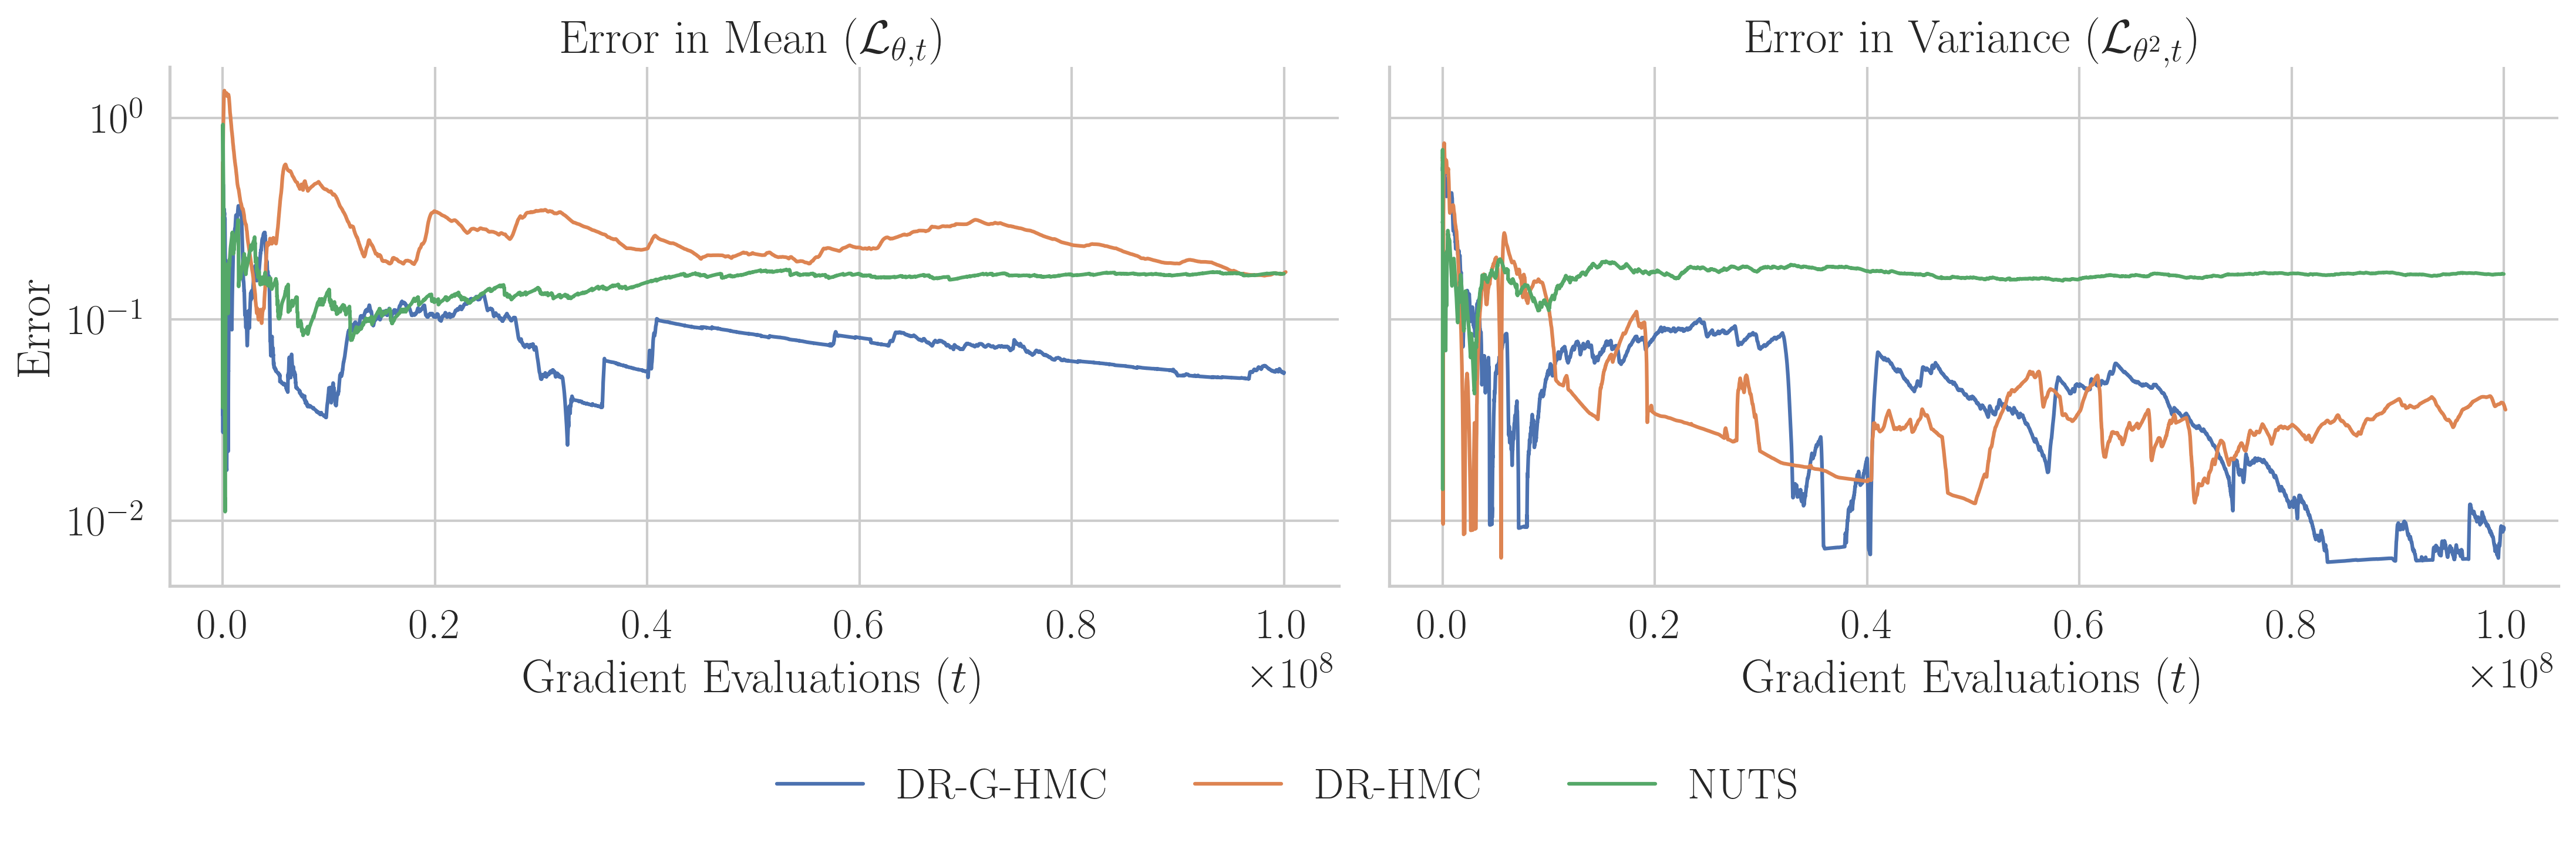

In [124]:
fig = sns.relplot(
    data=data,
    kind="line",
    x="Gradient Evaluations",
    y="Errors",
    hue="Sampler",
    # row="Sampler",
    col="Error Type",
    aspect=1.5, 
    # facet_kws={"sharey": "col"},
)
fig.set(yscale="log")        
# fig.set(ylim=(1e-3, 1e0))
fig.axes.flat[0].set_title(r'Error in Mean ($\mathcal{L}_{\theta, t}$)')
fig.axes.flat[1].set_title(r'Error in Variance ($\mathcal{L}_{\theta^2, t}$)')

fig.set_ylabels("Error")
fig.set_xlabels(r'Gradient Evaluations ($t$)')
fig.figure.subplots_adjust(bottom=0.3)
sns.move_legend(fig, "lower center", ncol=3, title="")